In [26]:
# Import libraries
import matplotlib.pyplot as plt
#from comet_ml import Experiment
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import scikitplot as skplt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig


# Import matplotlib
pd.plotting.register_matplotlib_converters()
get_ipython().run_line_magic('matplotlib', 'inline')


# Load training data
X_train = pd.read_csv(
    'train.csv')['Transcription']
X_valid = pd.read_csv(
    'valid.csv')['Transcription']
y_train = pd.read_csv('train.csv')['Type'] == 'Truthful'
y_valid = pd.read_csv(
    'valid.csv')['Type'] == 'Truthful'

# Load test data
test = pd.read_csv('test.csv')
X_test = test['Transcription']
y_test = test['Type'] == 'Truthful'

# Check data
print('Our training data has   ', len(X_train.index), ' rows.')
print('Our validation data has ', len(X_valid.index), ' rows.')
print('Our test data has       ', len(X_test.index), ' rows.')


# Allow us to see full text (not truncated)
pd.set_option('display.max_colwidth', None)


Our training data has    258  rows.
Our validation data has  32  rows.
Our test data has        30  rows.


In [27]:
########## Ensure reproducibility ##########


# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(42)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(42)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(42)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed=42)


In [28]:
print (y_train)

0      False
1      False
2      False
3       True
4       True
       ...  
253     True
254    False
255    False
256     True
257     True
Name: Type, Length: 258, dtype: bool


In [29]:
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 256


# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""

    input_ids = []
    attention_mask = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=MAX_LENGTH,
                                             padding='max_length',  # implements dynamic padding
                                             truncation=True,
                                             pad_to_max_length=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)


In [30]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_valid.tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())


In [31]:
MAX_LENGTH = 256 
LAYER_DROPOUT = 0.2
LEARNING_RATE = 3e-5
RANDOM_STATE = 42


def build_model(transformer, max_length=MAX_LENGTH):
    """""""""
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """""""""

    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(
        seed=RANDOM_STATE)

    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),
                                            name='input_ids',
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,),
                                                  name='input_attention',
                                                  dtype='int32')

    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer(
        [input_ids_layer, input_attention_layer])[0]

    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]

    D1 = tf.keras.layers.Dropout(LAYER_DROPOUT,
                                 seed=RANDOM_STATE
                                 )(cls_token)

    X = tf.keras.layers.Dense(128,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)

    D2 = tf.keras.layers.Dropout(LAYER_DROPOUT,
                                 seed=RANDOM_STATE
                                 )(X)

    # X = tf.keras.layers.Dense(32,
    #                           activation='relu',
    #                           kernel_initializer=weight_initializer,
    #                           bias_initializer='zeros'
    #                           )(D2)

    # D3 = tf.keras.layers.Dropout(LAYER_DROPOUT,
    #                              seed=RANDOM_STATE
    #                              )(X)

    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1,
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D2)

    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    # Compile the model
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [32]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2

# The bare, pretrained DistilBERT transformer model outputting raw hidden-states
# and without any specific head on top.
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT,
                          attention_dropout=DISTILBERT_ATT_DROPOUT,
                          output_hidden_states=True)
distilBERT = TFDistilBertModel.from_pretrained(
    'distilbert-base-uncased', config=config)

# Freeze DistilBERT layers to preserve pre-trained weights
for layer in distilBERT.layers:
    layer.trainable = False

# Build model
model = build_model(distilBERT)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [33]:
print(X_train_ids.shape)
print(X_train_attention.shape)
print(y_train.to_numpy().shape)
print(X_valid_ids.shape)
print(X_valid_attention.shape)
print(y_valid.to_numpy().shape)


(258, 256)
(258, 256)
(258,)
(32, 256)
(32, 256)
(32,)


In [34]:
EPOCHS = 6
BATCH_SIZE = 16
NUM_STEPS = len(X_train.index) // BATCH_SIZE
print(NUM_STEPS)

# Train the model
train_history1 = model.fit(
    x=[X_train_ids, X_train_attention],
    y=y_train.to_numpy(),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=NUM_STEPS,
    validation_data=([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=2
)


16
Epoch 1/6
16/16 - 36s - loss: 0.7035 - accuracy: 0.5195 - val_loss: 0.7097 - val_accuracy: 0.5312
Epoch 2/6
16/16 - 30s - loss: 0.7256 - accuracy: 0.4711 - val_loss: 0.7170 - val_accuracy: 0.4688
Epoch 3/6
16/16 - 30s - loss: 0.7264 - accuracy: 0.4628 - val_loss: 0.7338 - val_accuracy: 0.3438
Epoch 4/6
16/16 - 30s - loss: 0.6867 - accuracy: 0.5248 - val_loss: 0.7328 - val_accuracy: 0.3750
Epoch 5/6
16/16 - 30s - loss: 0.6954 - accuracy: 0.5413 - val_loss: 0.7207 - val_accuracy: 0.4375
Epoch 6/6
16/16 - 30s - loss: 0.7043 - accuracy: 0.4917 - val_loss: 0.7162 - val_accuracy: 0.5000


In [35]:
FT_EPOCHS = 4
BATCH_SIZE = 16
NUM_STEPS = len(X_train.index) // BATCH_SIZE
FT_LEARNING_RATE = 2e-5

# Unfreeze DistilBERT weights to enable fine-tuning
for layer in distilBERT.layers:
    layer.trainable = True

# Lower the learning rate to prevent destruction of pre-trained weights
optimizer = tf.keras.optimizers.Adam(lr=FT_LEARNING_RATE)

# Recompile model after unfreezing
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  min_delta=0,
                                                  patience=0,
                                                  restore_best_weights=True)

# Train the model
train_history2 = model.fit(
    x=[X_train_ids, X_train_attention],
    y=y_train.to_numpy(),
    epochs=FT_EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=NUM_STEPS,
    validation_data=([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/4
16/16 - 86s - loss: 0.7081 - accuracy: 0.5312 - val_loss: 0.8231 - val_accuracy: 0.2812
Epoch 2/4
16/16 - 76s - loss: 0.7285 - accuracy: 0.5372 - val_loss: 0.7000 - val_accuracy: 0.5938
Epoch 3/4
16/16 - 76s - loss: 0.6896 - accuracy: 0.5413 - val_loss: 0.6701 - val_accuracy: 0.5625
Epoch 4/4
16/16 - 76s - loss: 0.6415 - accuracy: 0.6488 - val_loss: 0.7357 - val_accuracy: 0.4375


Accuracy:   0.6333333333333333
ROC-AUC:    0.7053571428571429


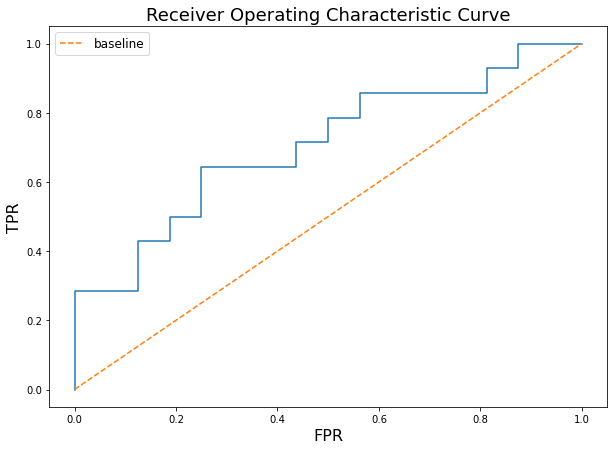

In [36]:

# Generate predictions
y_pred = model.predict([X_test_ids, X_test_attention])
y_pred_thresh = np.where(y_pred >=0.5, 1, 0)

# Get evaluation results
accuracy = accuracy_score(y_test, y_pred_thresh)
auc_roc = roc_auc_score(y_test, y_pred)

# Log the ROC curve
fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred)
 
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12)

print('Accuracy:  ', accuracy)    
print('ROC-AUC:   ', auc_roc)     


Minimum Validation Loss: 0.6701


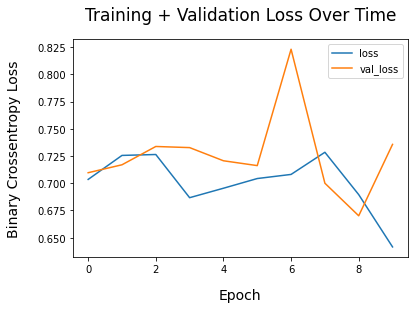

In [37]:
# Build train_history
history_df1 = pd.DataFrame(train_history1.history)
history_df2 = pd.DataFrame(train_history2.history)
history_df = history_df1.append(history_df2, ignore_index=True)

# Plot training and validation loss over each epoch
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title(label='Training + Validation Loss Over Time', fontsize=17, pad=19)
plt.xlabel('Epoch', labelpad=14, fontsize=14)
plt.ylabel('Binary Crossentropy Loss', labelpad=16, fontsize=14)
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# Save figure



Text(0, 0.5, 'True Label')

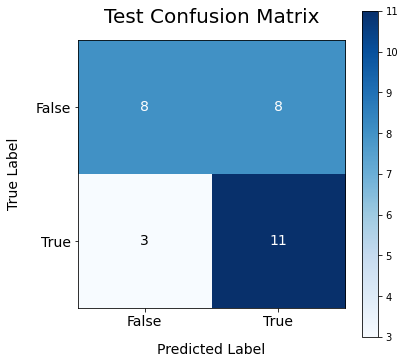

In [38]:
# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test.to_list(),
                                    y_pred_thresh.tolist(),
                                    figsize=(6, 6),
                                    text_fontsize=14)
plt.title(label='Test Confusion Matrix', fontsize=20, pad=17)
plt.xlabel('Predicted Label', labelpad=14)
plt.ylabel('True Label', labelpad=14)

